In [35]:
import pandas as pd
total = pd.read_csv('total.csv', encoding='latin-1')

In [36]:
total.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,month,year,Tag
0,80,26.0,2008-08-01 13:57:07,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,8,2008,flex
1,80,26.0,2008-08-01 13:57:07,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,8,2008,actionscript-3
2,80,26.0,2008-08-01 13:57:07,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,8,2008,air
3,90,58.0,2008-08-01 14:41:24,2012-12-26 03:45:49,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,8,2008,svn
4,90,58.0,2008-08-01 14:41:24,2012-12-26 03:45:49,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,8,2008,tortoisesvn


In [37]:
total.shape

(1048465, 10)

In [38]:
total['Body'][0]

'<p>I\'ve written a database generation script in <a href="http://en.wikipedia.org/wiki/SQL">SQL</a> and want to execute it in my <a href="http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime">Adobe AIR</a> application:</p>\r\r<pre><code>Create Table tRole (\r      roleID integer Primary Key\r      ,roleName varchar(40)\r);\rCreate Table tFile (\r    fileID integer Primary Key\r    ,fileName varchar(50)\r    ,fileDescription varchar(500)\r    ,thumbnailID integer\r    ,fileFormatID integer\r    ,categoryID integer\r    ,isFavorite boolean\r    ,dateAdded date\r    ,globalAccessCount integer\r    ,lastAccessTime date\r    ,downloadComplete boolean\r    ,isNew boolean\r    ,isSpotlight boolean\r    ,duration varchar(30)\r);\rCreate Table tCategory (\r    categoryID integer Primary Key\r    ,categoryName varchar(50)\r    ,parent_categoryID integer\r);\r...\r</code></pre>\r\r<p>I execute this in Adobe AIR using the following methods:</p>\r\r<pre><code>public static function RunSqlFromFile

In [39]:
from collections import Counter
import numpy as np 
import string
import re

In [40]:
def clean_text(text):
    global EMPTY
    EMPTY = ''
    
    if not isinstance(text, str): 
        return text
    text = re.sub('<pre><code>.*?</code></pre>', EMPTY, text)

    def replace_link(match):
        return EMPTY if re.match('[a-z]+://', match.group(1)) else match.group(1)
    
    text = re.sub('<a[^>]+>(.*)</a>', replace_link, text)
    return re.sub('<[^>]+>', EMPTY, text)

In [41]:
total['Text'] = total['Body'].apply(clean_text).str.lower()
total.Text = total.Text.apply(lambda x: x.replace('"','').replace("\n","").replace("\t",""))

In [42]:
total['Tag'].nunique()

21981

In [43]:
def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(10,6))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()

[('c#', 34977), ('java', 29263), ('php', 27835), ('javascript', 26194), ('jquery', 22807), ('android', 22193), ('c++', 14690), ('iphone', 14481), ('python', 13469), ('asp.net', 13433)]


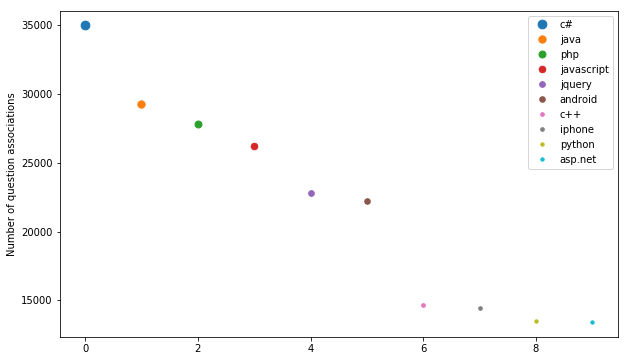

In [11]:
import collections
import matplotlib.pyplot as plt
tagCount =  collections.Counter(list(total['Tag'])).most_common(10)
print(tagCount)
plot_tags(tagCount)

In [44]:
total = total[(total.Tag == 'c#') | (total.Tag == 'java') | (total.Tag == 'php') | (total.Tag =='javascript') | (total.Tag =='jquery') | (total.Tag == 'android') | (total.Tag == 'c++') | (total.Tag == 'iphone') | (total.Tag == 'python') | (total.Tag == 'asp.net')]

In [45]:
total['Tag'].value_counts()

c#            34977
java          29263
php           27835
javascript    26194
jquery        22807
android       22193
c++           14690
iphone        14481
python        13469
asp.net       13433
Name: Tag, dtype: int64

In [60]:
from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.utils.extmath import density
from sklearn import metrics

In [47]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [48]:
# parse commandline arguments
op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")

<Option at 0x1a4bb48278: --filtered>

In [49]:
def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



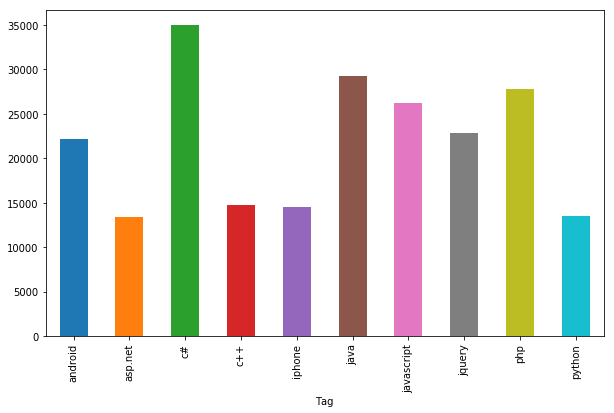

In [50]:
fig = plt.figure(figsize=(10,6))
total.groupby('Tag').Text.count().plot.bar(ylim=0)
plt.show()

In [51]:
col = ['Id', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Score', 'Title', 'Body', 'month', 'year']
total.drop(col, axis=1, inplace=True)

In [52]:
total = total.sample(frac=1).reset_index(drop=True)
total.head()

,Tag,Text
0,c#,i have two tabitems. user will enter some data...
1,python,python's unittest testrunner looks for setupmo...
2,javascript,i have an xslt file hosted www.mydomain.com/my...
3,android,i have found several tutorials for making a ti...
4,android,i'm writing media files share application.\r\r...


In [53]:
categories = total['Tag'].unique()

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(total['Text'], total['Tag'], random_state=42, test_size=0.2, shuffle=True)

In [55]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(X_train)
data_test_size_mb = size_mb(X_test)

print("%d documents - %0.3fMB (training set)" % (
    len(X_train), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(X_test), data_test_size_mb))
print("%d categories" % len(categories))
print()

175473 documents - 92.099MB (training set)
43869 documents - 23.062MB (test set)
10 categories



In [61]:
print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train_1 = vectorizer.transform(X_train)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train_1 = vectorizer.fit_transform(X_train)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train_1.shape)
print()

Extracting features from the training data using a sparse vectorizer
done in 12.389807s at 7.433MB/s
n_samples: 175473, n_features: 173624



In [62]:
print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test_1 = vectorizer.transform(X_test)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test_1.shape)
print()

Extracting features from the test data using the same vectorizer
done in 3.099743s at 7.440MB/s
n_samples: 43869, n_features: 173624



In [63]:
# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train_1 = ch2.fit_transform(X_train_1, y_train)
    X_test_1 = ch2.transform(X_test_1)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [64]:
target_names=categories

Ridge Classifier
________________________________________________________________________________
Training: 

/Users/sli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "



RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 33.990s
test time:  0.041s
accuracy:   0.691
dimensionality: 173624
density: 0.999999


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=None, n_iter=50, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)


/Users/sli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 28.230s
test time:  0.035s
accuracy:   0.562
dimensionality: 173624
density: 0.326743


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


/Users/sli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 33.418s
test time:  0.041s
accuracy:   0.591
dimensionality: 173624
density: 0.467007


Elastic-Net penalty
________________________________________________________________________________
Training: 


/Users/sli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 59.976s
test time:  0.037s
accuracy:   0.689
dimensionality: 173624
density: 0.006541


NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.652s
test time:  0.060s
accuracy:   0.602

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.911s
test time:  0.038s
accuracy:   0.608
dimensionality: 173624
density: 1.000000


__________________________________________________________

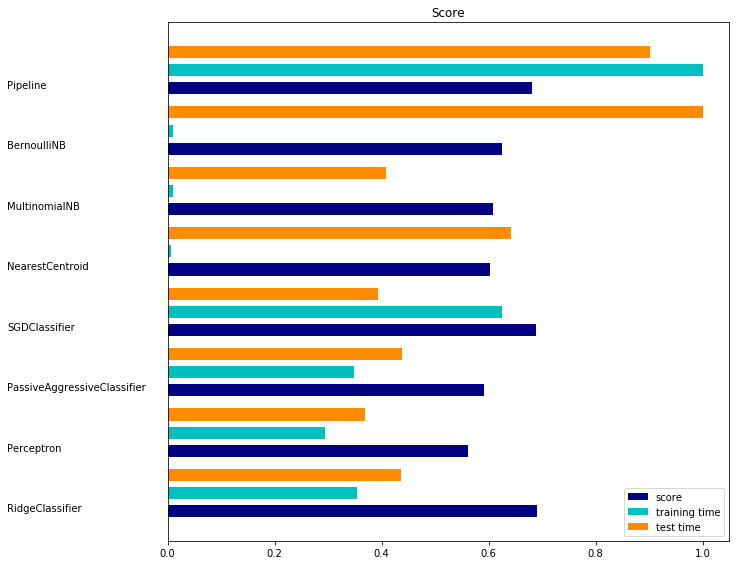

In [65]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train_1, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test_1)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    
# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [66]:
model = RidgeClassifier(tol=1e-2, solver="lsqr")
model.fit(X_train_1, y_train)
predicted = model.predict(X_test_1)
print(np.mean(predicted == y_test))

/Users/sli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


0.691239827668741


In [68]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted, target_names=target_names))

             precision    recall  f1-score   support

         c#       0.80      0.82      0.81      4486
     python       0.54      0.46      0.50      2719
 javascript       0.62      0.72      0.67      7048
    android       0.79      0.69      0.74      2937
        php       0.88      0.83      0.85      2921
       java       0.75      0.73      0.74      5851
        c++       0.54      0.48      0.51      5193
     jquery       0.56      0.58      0.57      4465
    asp.net       0.72      0.81      0.76      5628
     iphone       0.89      0.75      0.81      2621

avg / total       0.69      0.69      0.69     43869

